In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, classification_report

In [148]:
X, y = make_circles(n_samples=300, random_state= 42, noise= 0.05)

<Axes: >

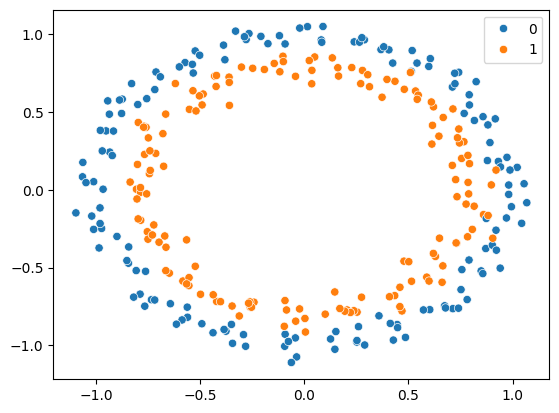

In [149]:
sns.scatterplot(x= X[:, 0], y= X[: , 1], hue= y)

In [150]:
#shape
y= y.reshape(-1, 1)

print(f"X shape= {X.shape}")
print(f"y shape= {y.shape}")

X shape= (300, 2)
y shape= (300, 1)


In [151]:
#no need to scale the data it seems
X_df = pd.DataFrame(X, columns= ['x1', 'x2'])
X_df.describe()

,x1,x2
count,300.000000,300.000000
mean,0.000413,0.003196
std,0.639926,0.644319
min,-1.096241,-1.110559
25%,-0.589894,-0.645834
50%,-0.009180,0.030776
75%,0.613389,0.620338
max,1.068361,1.049773


In [152]:
#adding necessary details for circular pattern
X_df[['x1_squared', 'x2_squared']]= X_df[['x1', 'x2']]**2
X_df

,x1,x2,x1_squared,x2_squared
0,-0.423210,0.664122,0.179107,0.441058
1,0.253588,-0.786730,0.064307,0.618943
2,0.726874,0.065216,0.528346,0.004253
3,0.881626,0.416984,0.777264,0.173875
4,-0.753402,-0.269957,0.567615,0.072877
...,...,...,...,...
295,0.024081,0.830758,0.000580,0.690158
296,-0.921683,0.219879,0.849499,0.048347
297,-0.291607,-0.931515,0.085035,0.867721
298,0.170886,-0.763740,0.029202,0.583299


In [153]:
X_train, X_test, y_train, y_test= train_test_split(X_df[['x1_squared', 'x2_squared']], y, random_state= 42, test_size= 0.2)

print(f"X_train shape= {X_train.shape}")
print(f"y_train shape= {y_train.shape}")
print(f"X_test shape= {X_test.shape}")
print(f"y_test shape= {y_test.shape}")


X_train shape= (240, 2)
y_train shape= (240, 1)
X_test shape= (60, 2)
y_test shape= (60, 1)


In [154]:
X_train= X_train.to_numpy()
X_train= np.c_[np.ones(X_train.shape[0]) ,X_train]

In [155]:
def compute_cost(y_train, p_preds, lamda, W):
    m= y_train.shape[0]
    J= (-1/m) * np.sum((y_train* np.log(p_preds)) + ((1- y_train)* np.log(1-p_preds))) + (lamda/(2*m)) * np.sum(W**2)
    return J

In [156]:
def sigmoid(z):
    return 1/ (1+ np.exp(-z))

In [157]:
def gradient_descent(X_train, y_train, W_b_init, alpha, epochs, lamda):
    cost_hist= []
    W_b= W_b_init.copy()
    m= X_train.shape[0]

    for i in range(epochs):
        z= X_train @ W_b
        p_preds= sigmoid(z)
        dJ_dW_b = (-1/m)* (X_train.T @ (y_train-p_preds))

        #regularizing with weights, not touching bias
        dJ_dW_b[1:] += (1/m)* lamda* W_b[1:]

        #updating weights and bias
        W_b -= alpha* dJ_dW_b 

        if i%5 ==0:
            J= compute_cost(y_train, p_preds, lamda, W_b[1:])
            cost_hist.append(J) 
    
    return W_b, cost_hist


In [158]:
#training data
W_b_init= np.zeros(X_train.shape[1]).reshape(-1, 1)
epochs= 20000 
alpha= 0.0001
lamda= 0.1

W_b, cost_hist = gradient_descent(X_train, y_train, W_b_init, alpha, epochs, lamda)

In [159]:
def predict(X_test, W_b_test, threshold):
    p_preds= sigmoid(X_test @ W_b_test)
    y_pred= (p_preds.flatten() >= threshold).astype(int)

    return p_preds.flatten(), y_pred

In [160]:
#determining optimal threshold using youden's index
X_test_b= np.c_[np.ones(X_test.shape[0]),X_test]
test_preds= sigmoid(X_test_b @ W_b).flatten()

fpr, tpr, thresholds= roc_curve(y_test.flatten(), test_preds)
youden_index= tpr-fpr
optimal_index= np.argmax(youden_index)
optimal_threshold= thresholds[optimal_index]

print(f"Optimal Threshold (Youden): {optimal_threshold:.3f}")
print(f"AUC Score: {roc_auc_score(y_test, test_preds):.3f}")

Optimal Threshold (Youden): 0.479
AUC Score: 1.000


In [161]:
#making predictions
final_probs, final_preds = predict(X_test_b, W_b, optimal_threshold)

In [162]:
#classification report
print(classification_report(y_true= y_test, y_pred= final_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        34

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



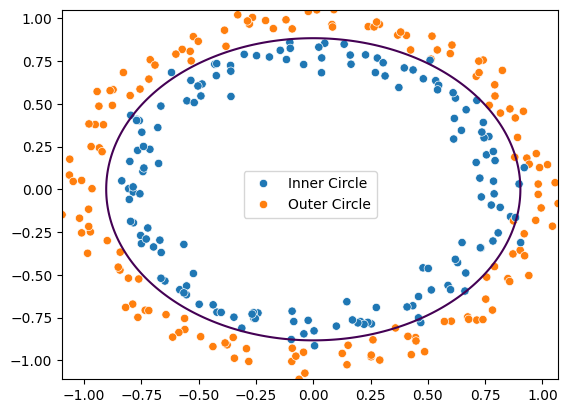

In [163]:
#calculating the decision boundary
boundary_z= np.log(optimal_threshold/ (1- optimal_threshold))

x1= np.linspace(X[:, 0].min(), X[:, 0].max(), 500)
x2= np.linspace(X[:, 1].min(), X[:, 1].max(), 500)

X1, X2 = np.meshgrid(x1, x2)
X1_sq= X1**2
X2_sq= X2**2

Z= W_b[0]+ W_b[1]* X1_sq + W_b[2] * X2_sq - boundary_z

y_hue= y.flatten()
y_labelled= np.where(y_hue== 0, 'Outer Circle', 'Inner Circle')

#plotting decision boundary
sns.scatterplot(x= X[:, 0], y= X[: , 1], hue= y_labelled)
plt.contour(X1, X2, Z, levels= [0])
plt.show()

Text(0.5, 1.0, 'Confusion matrix')

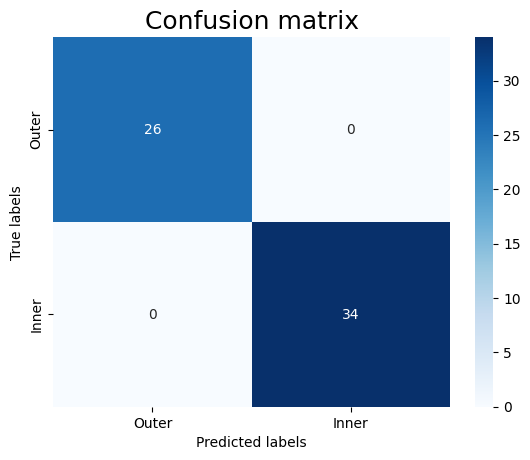

In [164]:
cm= confusion_matrix(y_true= y_test, y_pred= final_preds)
sns.heatmap(cm, annot= True, cmap= 'Blues', xticklabels= ['Outer', 'Inner'], yticklabels= ['Outer', 'Inner'], cbar= True, linecolor= 'black')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix' ,fontsize= 18)

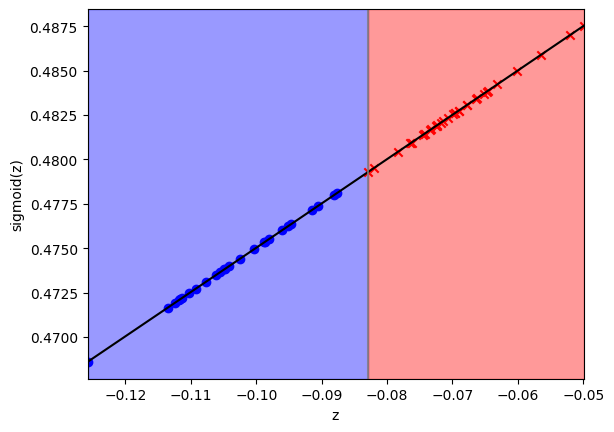

In [165]:
#Plotting
z= (X_test_b @ W_b).flatten()
sort_idx= np.argsort(z)


z_sorted= z[sort_idx]
sigmoid_z= sigmoid(z_sorted)
threshold_x= np.log(optimal_threshold / (1 - optimal_threshold))
y_actual= y_test[sort_idx].flatten()

outer_circle= (y_actual== 0)
inner_circle= (y_actual== 1)

#creating basic plot
plt.plot(z_sorted,sigmoid_z, c= 'black')
plt.xlabel('z')
plt.ylabel('sigmoid(z)')

#creating threshold coloring
plt.axvspan(xmin=z_sorted.min(), xmax=threshold_x, color='blue', alpha=0.4, label='Outer circle')
plt.axvspan(xmin=threshold_x, xmax=z_sorted.max(), color='red', alpha=0.4, label='Inner circle')
plt.xlim(z_sorted.min(), z_sorted.max())
plt.axvline(x=threshold_x, c='gray', alpha=0.8, linewidth=1.5)

#plotting the predictions and probabilities
plt.scatter(x= z_sorted[outer_circle], y=sigmoid_z[outer_circle], marker= 'o', c= 'blue')
plt.scatter(x= z_sorted[inner_circle], y=sigmoid_z[inner_circle], marker= 'x', c= 'red')